# assist0910 dataset preprocessing
### Import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import pandas as pd
import numpy as np
from liriscat.dataset.preprocessing_utilities import *
from liriscat.utils import utils
import torch
utils.set_seed(0)

CUDA is not available. Skipping CUDA seed setting.
CUDA is not available. Skipping CUDA seed setting.


### Load and merge dataset

In [3]:
raw_data = pd.read_csv('../1-raw_data/assist0910.csv', encoding="ISO-8859-15", low_memory=False)

raw_data = raw_data.drop(columns=['order_id', 'assignment_id', 'assistment_id',
       'original',  'attempt_count', 'ms_first_response', 'answer_type',
       'tutor_mode', 'sequence_id', 'student_class_id',
       'position', 'type', 'base_sequence_id',  'skill_name',
       'teacher_id', 'school_id', 'hint_count', 'hint_total', 'overlap_time',
       'template_id', 'answer_id', 'answer_text', 'first_action',
       'bottom_hint', 'opportunity', 'opportunity_original'])

raw_data =  raw_data.rename(columns={"skill_id": "dimension_id", "problem_id":"item_id"})
raw_data.head()

,user_id,item_id,correct,dimension_id
0,64525,51424,1,1.0
1,64525,51435,1,1.0
2,70363,51444,0,1.0
3,70363,51395,1,1.0
4,70363,51481,0,1.0


### Split rows with several dimensions

In [4]:
#raw_data['dimension_id'] = raw_data['dimension_id'].apply(lambda x: set(map(int,
#x.strip('{}').split(', '))))
df_expanded = raw_data.explode('dimension_id').reset_index(drop=True)
df_expanded.head()

,user_id,item_id,correct,dimension_id
0,64525,51424,1,1.0
1,64525,51435,1,1.0
2,70363,51444,0,1.0
3,70363,51395,1,1.0
4,70363,51481,0,1.0


### Early stats

In [5]:
print(len(df_expanded))
all_data = df_expanded.dropna(subset=['user_id','item_id','correct','dimension_id'])
print(len(all_data))

525534
459208


In [6]:
stat_unique(all_data, None)
stat_unique(all_data, ['user_id', 'item_id'])
stat_unique(all_data, 'user_id')
stat_unique(all_data, 'item_id')
stat_unique(all_data, 'dimension_id')

Total length: 459208
Number of unique [user_id,item_id]: 278876
Number of unique user_id: 4163
Number of unique item_id: 17751
Number of unique dimension_id: 123


### Clean Nan values

In [7]:
cleaned_data = all_data.dropna(subset=['user_id','item_id','correct','dimension_id'], axis='index')

### Remove duplicated user and id rows

In [8]:
unduplicated_data = remove_duplicates(cleaned_data,key_attrs=['user_id','item_id','dimension_id'],agg_attrs=[])

### Filter Data

In [9]:
filtered_data_0 = unduplicated_data
filtered_q_nb = 1
filtered_u_nb = 0
filtered_d_nb = 0
while filtered_q_nb!=0 or filtered_u_nb!=0 or filtered_d_nb!=0 : 
    # filter items
    filtered_data_1, filtered_q_nb = densify(filtered_data_0,'item_id','user_id',5)
    # filter users
    min_nb_users_logs = 20
    filtered_data_2, filtered_u_nb = densify(filtered_data_1,'user_id','item_id',min_nb_users_logs)
    # filter knowledges
    filtered_data_3, filtered_d_nb = densify(filtered_data_2,'dimension_id','item_id',1)
    filtered_data_0 = filtered_data_3
    
stat_unique(filtered_data_0, None)
stat_unique(filtered_data_0, ['user_id', 'item_id'])
stat_unique(filtered_data_0, 'user_id')
stat_unique(filtered_data_0, 'item_id')
stat_unique(filtered_data_0, 'dimension_id')

filter 4733 item_id
filter 2074 user_id
filter 0 dimension_id
filter 318 item_id
filter 17 user_id
filter 0 dimension_id
filter 16 item_id
filter 3 user_id
filter 0 dimension_id
filter 3 item_id
filter 0 user_id
filter 0 dimension_id
filter 0 item_id
filter 0 user_id
filter 0 dimension_id
Total length: 296648
Number of unique [user_id,item_id]: 248490
Number of unique user_id: 2052
Number of unique item_id: 12667
Number of unique dimension_id: 113


### Encoding

In [10]:
# renumber the users
u_enc_data, u2n = encode_attr(filtered_data_0, "user_id")

In [11]:
# renumber the items
q_enc_data, q2n = encode_attr(u_enc_data, "item_id")

In [12]:
# renumber the dimensions
d_enc_data, d2n = encode_attr(q_enc_data, "dimension_id")

### Maps creation

In [13]:
q2k, k2q = create_q2k(d_enc_data)

In [14]:
resc_data = d_enc_data
resc_data['correct'] = resc_data['correct'].astype(float)
min_val = resc_data['correct'].min()
max_val = resc_data['correct'].max()
resc_data['correct'] = (resc_data['correct']-min_val)/(max_val-min_val) +1
print(f'min value : {resc_data["correct"].min()}, max value : {resc_data["correct"].max()}')

min value : 1.0, max value : 2.0


In [15]:
stat_unique(resc_data, None)
stat_unique(resc_data, ['user_id', 'item_id'])
stat_unique(resc_data, 'user_id')
stat_unique(resc_data, 'item_id')
stat_unique(resc_data, 'dimension_id')
stat_unique(resc_data, 'correct')

resc_data_dim_grouped_items = resc_data.groupby("dimension_id")["item_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("dimension_id")["user_id"].nunique()
print('#questions/category: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_items),int(np.round(np.mean(resc_data_dim_grouped_items))),np.max(resc_data_dim_grouped_items)))
print('#users/category: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_users),int(np.round(np.mean(resc_data_dim_grouped_users))),np.max(resc_data_dim_grouped_users)))

resc_data_dim_grouped_items = resc_data.groupby("item_id")["dimension_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("item_id")["user_id"].nunique()
print('#categorys/question: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_items),int(np.round(np.mean(resc_data_dim_grouped_items))),np.max(resc_data_dim_grouped_items)))
print('#users/question: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_users),int(np.round(np.mean(resc_data_dim_grouped_users))),np.max(resc_data_dim_grouped_users)))

resc_data_dim_grouped_items = resc_data.groupby("user_id")["item_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("user_id")["dimension_id"].nunique()
max_nb_q_per_users = np.max(resc_data_dim_grouped_items)
print('#questions/users: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_items),int(np.round(np.mean(resc_data_dim_grouped_items))),np.max(resc_data_dim_grouped_items)))
print('#categorys/users: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_users),int(np.round(np.mean(resc_data_dim_grouped_users))),np.max(resc_data_dim_grouped_users)))

Total length: 296648
Number of unique [user_id,item_id]: 248490
Number of unique user_id: 2052
Number of unique item_id: 12667
Number of unique dimension_id: 113
Number of unique correct: 2
#questions/category: 1 & 135 &  978
#users/category: 5 & 317 &  1072
#categorys/question: 1 & 1 &  4
#users/question: 5 & 20 &  152
#questions/users: 20 & 121 &  986
#categorys/users: 1 & 17 &  88


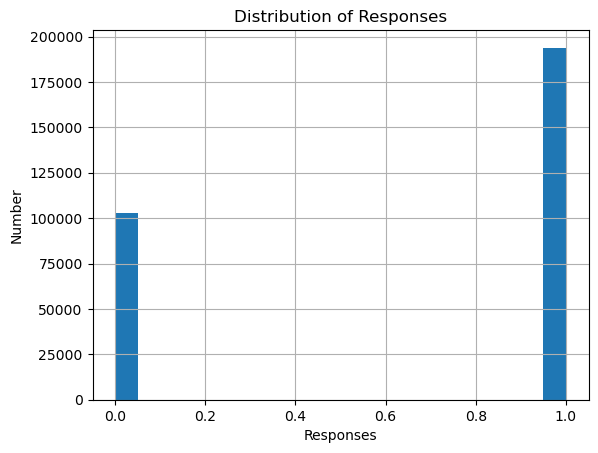

In [16]:
import matplotlib.pyplot as plt

# draw a histogram of the age column
(resc_data['correct']-1).hist(bins=20)

# add labels and title
plt.xlabel('Responses')
plt.ylabel('Number')
plt.title('Distribution of Responses')
plt.savefig('../4-figs/distribution_assist0910.png')


In [17]:
resc_data_dim_grouped_items = resc_data.groupby("item_id")["dimension_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("item_id")["user_id"].nunique()
metadata = get_metadata(resc_data,["user_id", "item_id", "dimension_id"])
metadata['min_nb_users_logs'] = min_nb_users_logs
metadata['max_nb_categories_per_question'] = int(np.max(resc_data_dim_grouped_items))
metadata['max_nb_questions_per_user'] = int(max_nb_q_per_users)

### Compute nb of modalities per item

In [18]:
nb_modalities = get_modalities_nb(resc_data, metadata)

### Save data, concept map, metadata and nb_modalities

In [19]:
new_order = ['user_id','item_id', 'correct', 'dimension_id']
resc_data = resc_data[new_order]

In [20]:
# save selected data
resc_data.to_csv('../1-raw_data/assist0910_selected_data.csv', index=False)

In [21]:
# Convert int64 keys to str
q2k_str_keys = {str(key): value for key, value in q2k.items()}

# Convert sets to lists in the dictionary
q2k_json_serializable = {}
for key, value in q2k_str_keys.items():
    if isinstance(value, set):
        q2k_json_serializable[key] = list(value)
    else:
        q2k_json_serializable[key] = value

# Save concept map
with open('../2-preprocessed_data/assist0910_concept_map.json', 'w') as f:
    json.dump(q2k_json_serializable, f)

In [22]:
# save metadata
with open('../2-preprocessed_data/assist0910_metadata.json', 'w') as f:
    json.dump(metadata, f)

In [23]:
# save metadata
torch.save(nb_modalities,'../2-preprocessed_data/assist0910_nb_modalities.pkl')

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
from liriscat import utils
utils.setuplogger(verbose = True,log_path = "../../logs/", log_name="liriscat")
utils.set_seed(0)

CUDA is not available. Skipping CUDA seed setting.


In [26]:
import pandas as pd
from liriscat.dataset.preprocessing_utilities import *
resc_data = pd.read_csv('../1-raw_data/assist0910_selected_data.csv')

In [27]:
train, valid, test = split_users(resc_data, 5)

## save data

In [28]:
for i_fold, train_fold in enumerate(train):
    save_df_to_csv(train[i_fold], f'../2-preprocessed_data/assist0910_train_{i_fold}.csv')
    save_df_to_csv(valid[i_fold], f'../2-preprocessed_data/assist0910_valid_{i_fold}.csv')
    save_df_to_csv(test[i_fold], f'../2-preprocessed_data/assist0910_test_{i_fold}.csv')

    train_valid_df = pd.concat([train[i_fold], valid[i_fold]])
    # Split the merged data horizontally into train and validation sets.

    quadruplet = quadruplet_format(train_valid_df)
    vertical_train, vertical_valid = split_data_vertically_unique_fold(quadruplet, valid_prop=0.2)

    save_df_to_csv(vertical_train, f'../2-preprocessed_data/assist0910_vert_train_{i_fold}.csv')
    save_df_to_csv(vertical_valid, f'../2-preprocessed_data/assist0910_vert_valid_{i_fold}.csv')